In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Analyse Moyenne-Variance

### Cas n = 2

Dans un premier temps, exposons la théorie de Markowitz et de son analyse moyenne-variance dans le cas particulier où notre portefeuille contient 2 actifs, A et B.

Concentrons nous tout d'abord sur l'impact de la diversification du portefeuille. Pour rappel, la diversification du portefeuille, dans sa plus simple des formes, est représentée par les coefficients de corrélations linéaires entre les différents actifs qui le composent.

Un portefeuille diversifié doit être construit de telle sorte que les actifs qui le composent soient faiblement voir négativement corrélés entre eux ce qui tendrait à stabiliser la volatilité globale du portefeuille. Les actifs n'évoluent pas dans la même direction ou du moins pas avec la même intensité.

Dans la cellule suivante, je vais vous illustrer l'impact de ce coefficient en construisant dans le plan (sigma_p, mu_p) les graphes représentants l'ensemble des portefeuilles pour un certain coefficient de corrélation.

In [2]:
# Paramètres
mu_a = 0.02  # Moyenne des rendements de l'actif A
mu_b = 0.05  # Moyenne des rendements de l'actif B
sigma_a = 0.10  # Écart-type des rendements de l'actif A
sigma_b = 0.20  # Écart-type des rendements de l'actif B
w_a = np.linspace(0, 1, 100) # Liste des poids appliqués à l'actif A
w_b = 1 - w_a # Liste des poids appliqués à l'actif B

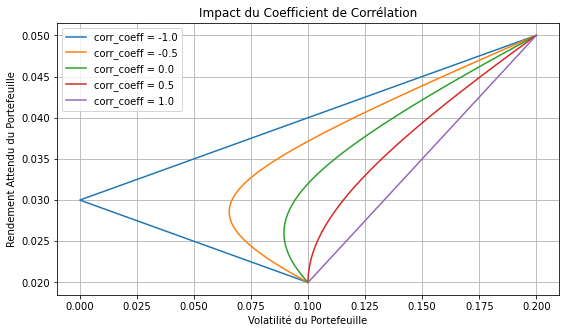

In [3]:
# Tracé des figures
plt.figure(figsize=(9, 5))
for corr_coeff in np.linspace(-1, 1, 5):
    mu_p = w_a * mu_a + w_b * mu_b
    sigma_p = np.sqrt((w_a * sigma_a)**2 + (w_b * sigma_b)**2 + 2 * w_a * w_b * corr_coeff * sigma_a * sigma_b)
    plt.plot(sigma_p, mu_p, label=f"corr_coeff = {corr_coeff}")

plt.xlabel('Volatilité du Portefeuille')
plt.ylabel('Rendement Attendu du Portefeuille')
plt.title('Impact du Coefficient de Corrélation')
plt.legend()
plt.grid(True)
plt.show()

### Conclusions graphiques et théoriques

Ainsi, nous observons nettement que plus le coefficient de corrélation entre les deux actifs est bas plus le niveau de risque pour un même rendement l'est aussi. 

Markowitz a ainsi démontré l'intérêt fondamental de la diversification dans l'investissement en expliquant que si nous prenons deux portefeuilles différents par les actifs qui les composent et par leurs corrélations linéaires entre eux, mais similaires par les performances et les niveaux de risques individuels, alors le portefeuille présentant les actifs les moins corrélés entre eux saura moins risqué pour un même niveau de rendement.

La diversification ne vise pas à maximiser le rendement mais à minimiser le risque pour un même niveau de rendement.
Mathématiquement, on dira que l'esperance de rendement n'est pas fonction du coeff de corrélation.

$$
\mu_P = w_A \cdot \mu_A + w_B \cdot \mu_B
$$


Analysons désormais plus en profondeur les cas pour des valeurs particulières du coefficient de corrélation.

- Cas corr_coef = 1

$$
\sigma^2_p = w_A^2 \cdot \sigma_A^2 + w_B^2 \cdot \sigma_B^2 + 2 \cdot w_A \cdot w_B \cdot \sigma_A \cdot \sigma_B
$$

Graphiquement pour ce cas, nous observons que les deux actifs sont réliés par un segment de droite. Cette progession linéaire s'explique par le fait que pour un coeff égal à 1. La rentabilité espérée et le risque du portefeuille sont des moyennes pondérées resp. de la rentabilité espérées et du risque des deux titres.

Dans ce cas de figure, il est clair qu'il est impossible d'obtenir un niveau de risque inférieur à celui de l'actif le moins risqué. 

- Cas -1 < corr_coef < 1

Pour rappel, P est un portefeuille composé d'un actif A et d'un actif B.
Notons x et (1-x) leur poids respectif dans le portefeuille.

Determinons dans ces cas, le poids de variance minimale qui correspond à la dérivée première de la variance du portefeuille par rapport.

$$
\sigma^2_p = x^2 \cdot \sigma^2_A + (1 - x)^2 \cdot \sigma^2_B + 2 \cdot x \cdot (1 - x) \cdot \rho \cdot \sigma_A \cdot \sigma_B
$$

$$
\frac{d}{dx} (\sigma^2_p) = x \cdot \sigma^2_A - (1 - x) \cdot \sigma^2_B + (1 - 2x) \cdot \rho \cdot \sigma_A \cdot \sigma_B = 0
$$

$$
x* = \frac{\sigma^2_B - \rho \cdot \sigma_A \cdot \sigma_B}{(\sigma^2_A + \sigma^2_B - \rho \cdot \sigma_A \cdot \sigma_B)}
$$

Ainsi, pour ce portefeuille nous avons la variance suivante:

$$
\sigma^2_p = \frac{\sigma^2_A \sigma^2_B (1 - \rho^2)}{\sigma^2_A + \sigma^2_B - 2 \rho \sigma_A \sigma_B}
$$

En supposant que l'actif A est l'actif avec la variance la plus faible et donc le moins risqué, calculons le delta de risque entre ces deux grandeurs.

$$
\delta = - \frac{\sigma^2_A (\sigma_A - \rho \sigma_B)^2}{\sigma^2_A + \sigma^2_B - 2 \rho {\sigma_A \sigma_B}} 
$$

Ainsi on comprend que si le coefficient n'est pas égal au rapport des écarts type avec au numérateur l'écart type de l'actif A (le moins risqué), le rendement du portefeuille sera toujours inférieur à celui de l'actif le moins risqué.

Ce que l'on peut aussi en déduire vis à vis de la valeur de x* est que si le coefficient de corrélation est supérieur à ce rapport alors la valeur du poids sera positive, sinon elle sera négative et on sera dans le cadre d'une vente à découvert sur l'actif A et d'un achat à effet de levier sur l'actif B.

En revanche, si le coefficient de corrélation est égal à ce rapport alors le niveau de risque du portefeuille sera égal à celui de l'actif le moins risqué. Seul cas où la diversification ne joue pas (Cf. courbe --> corr_coef = 0.5).

- Cas corr_coef = -1

Seul cas où le niveau de risque minimal est nul, pour une certain allocation.

<u>Conclusion</u>:

Si nous devons retenir une chose c'est que la diversification joue son rôle de minimiseur de risque à partir du moment où le coefficient de corrélation est inférieur à 1 et différent du rapport des deux ecart types (moins risqué au numérateur).

Coefficient de corrélation: -1.0
Ponderation actif A 0.6667
Pondération actif B 0.3333
Rendement du portefeuille 0.03
Volatilité du portefeuille 0.0


Coefficient de corrélation: -0.5
Ponderation actif A 0.7143
Pondération actif B 0.2857
Rendement du portefeuille 0.0286
Volatilité du portefeuille 0.0655


Coefficient de corrélation: 0.0
Ponderation actif A 0.8
Pondération actif B 0.2
Rendement du portefeuille 0.026
Volatilité du portefeuille 0.0894


Coefficient de corrélation: 0.5
Ponderation actif A 1.0
Pondération actif B 0.0
Rendement du portefeuille 0.02
Volatilité du portefeuille 0.1


Coefficient de corrélation: 1.0
Ponderation actif A 2.0
Pondération actif B -1.0
Rendement du portefeuille -0.01
Volatilité du portefeuille 0.0




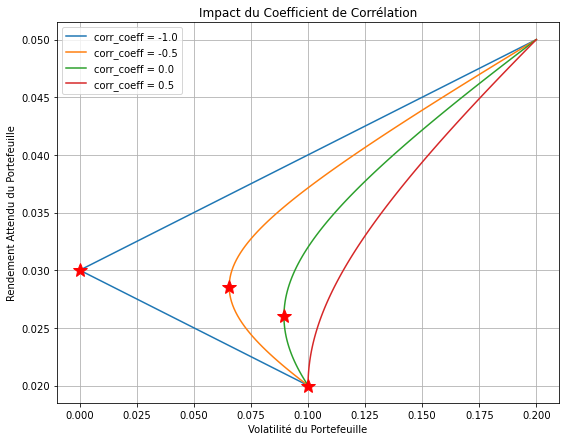

In [4]:
# Tracés des figures avec en plus le point de variance minimale
plt.figure(figsize=(9, 7))
for corr_coeff in np.linspace(-1, 1, 5):
    mu_p = w_a * mu_a + w_b * mu_b
    sigma_p = np.sqrt(w_a**2 * sigma_a**2 + w_b**2 * sigma_b**2 + 2 * w_a * w_b * corr_coeff * sigma_a * sigma_b)
    # Reporting
    x = (sigma_b**2 - corr_coeff * sigma_a * sigma_b) / (sigma_a**2 + sigma_b**2 - 2 * corr_coeff * sigma_a * sigma_b)
    mu_p_var_min = x * mu_a + (1-x) * mu_b
    sigma_p_min = np.sqrt(x**2 * sigma_a**2 + (1 - x)**2 * sigma_b**2 + 2 * x * (1 - x) * corr_coeff * sigma_a * sigma_b)
    print("Coefficient de corrélation:", corr_coeff)
    print("Ponderation actif A", round(x, 4))
    print("Pondération actif B", round(1-x, 4))
    print("Rendement du portefeuille", round(mu_p_var_min, 4))
    print("Volatilité du portefeuille", round(sigma_p_min, 4))
    print("\n")
    # Tracés
    if corr_coeff == 1.0: # Cas vente à découvert
        continue
    plt.plot(sigma_p, mu_p, label=f"corr_coeff = {corr_coeff}")
    plt.plot(sigma_p_min, mu_p_var_min, color="red", marker="*", markersize=15)

    
plt.xlabel('Volatilité du Portefeuille')
plt.ylabel('Rendement Attendu du Portefeuille')
plt.title('Impact du Coefficient de Corrélation')
plt.legend()
plt.grid(True)
plt.show()

### Cas à n actifs

Considérons désormais un portefeuille composé de n actifs risqués avec n > 2.

w : vecteur R^n contenant les poids attribués à chaque actifs

$$
w = \begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{bmatrix}
$$

R : vecteur R^n contenant les rentabilités de chaque actifs

$$
\mu = \begin{bmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_n
\end{bmatrix}
$$

e : vecteur de R^n dont toutes les composantes sont égales à 1

V : matrice de variances-covariances (n, n) des rentabilités des actifs financiers. On supposera que notre portefeuille est diversifié et que chaque actif n'est pas linéairement dépendant aux autres, ainsi nous considérerons que cette matrice est inversible. Cette hypothèse nous permettra de bénéficier de certaines propriétés simplificatrices.

La diversification garantit l'hypothése d'une solution unique pour les problèmes d'optimisations à suivre. 

$$
\Sigma = \begin{bmatrix}
\sigma_{1}^2 & \sigma_{1,2} & \cdots & \sigma_{1,n} \\
\sigma_{2,1} & \sigma_{2}^2 & \cdots & \sigma_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
\sigma_{n,1} & \sigma_{n,2} & \cdots & \sigma_{n}^2
\end{bmatrix}
$$

Rendement espéré du portefeuille

$$
E(R_p) = \mathbf{w}^T \cdot \boldsymbol{\mu} = \sum_{i=1}^{n} w_i \cdot \mu_i
$$

Variance attendue du portefeuille

$$
\sigma^2_p = \mathbf{w}^T \cdot \boldsymbol{\Sigma} \cdot \mathbf{w} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i \cdot w_j \cdot \sigma_{ij} = \sum_{i=1}^{n} w_i^2 \cdot \sigma_i^2 + 2 \cdot \sum_{i=1}^{n} \sum_{j=i+1}^{n} w_i \cdot w_j \cdot \sigma_{ij}
$$

Calculons désormais la dérivée partielle de cette variance par rapport au poids du vecteur w du portefeuille:

$$
\frac{\partial \sigma_p^2}{\partial w_i} = \frac{\partial}{\partial w_i} (\mathbf{w}^T \cdot \boldsymbol{\Sigma} \cdot \mathbf{w})
$$

$$
\frac{\partial \sigma_p^2}{\partial w_i} = \frac{\partial (\mathbf{w}^T \cdot \boldsymbol{\Sigma} \cdot \mathbf{w})}{\partial (\mathbf{w}^T)} \cdot \frac{\partial (\mathbf{w}^T)}{\partial w_i} + \frac{\partial (\mathbf{w}^T \cdot \boldsymbol{\Sigma} \cdot \mathbf{w})}{\partial \boldsymbol{\Sigma}} \cdot \frac{\partial \boldsymbol{\Sigma}}{\partial w_i} + \frac{\partial (\mathbf{w}^T \cdot \boldsymbol{\Sigma} \cdot \mathbf{w})}{\partial \mathbf{w}} \cdot \frac{\partial \mathbf{w}}{\partial w_i}
$$

$$
\frac{\partial \sigma_p^2}{\partial w_i} = 2 \cdot (\boldsymbol{\Sigma} \cdot \mathbf{w})_i = 2 \cdot \sum_{j=1}^{n} \sigma_{ij} \cdot w_j
$$


Cette dernière expression montre que la contribution marginale d'un titre au risque total du portefeuille se mesure par la covariance entre les rendements de l'actif et ceux du portefeuille. De même, on peut démontrer cette même propriété en appliquant une équipondération des actifs du portefeuille à 1/n (Hint: mettre en évidence deux moyennes).

Vous pourrez conclure qu'un portefeuille comprenant un grand nombre d'actifs voit sa variance tendre vers sa covariance moyenne. Ceci indique que dans le contexte d'un portefeuille bien diversifié seules les covariances impactent le portefeuille.

La determination de l'ensemble des portefeuilles minimisant la variance pour une espérance de rentabilité fixée passe par la résolution du problème d'optimisation quadratique :

- Rendement espéré fixé : $w^T \mu = \bar{r}_p$ (contrainte de rendement)
- Somme des poids égale à 1 : $w^T \mathbf{1} = 1$ (contrainte de budget)

La fonction objective à minimiser est : $\sigma_p^2 = w^T \Sigma w$

Notez ici qu'il n'y aucune contrainte de non négativité des poids ce qui signifie que les ventes à découvert sont autorisées.

Ainsi, par la méthode des lagrangiens, le problème d'optimisation sous contrainte devient le problème d'optimisation libre suivant:

$$
Min[\mathcal{L}(w, \lambda, \alpha) = w^T \Sigma w + \lambda (\bar{r}_p - w^T \mu) + \alpha (w^T \mathbf{1} - 1)]
$$

Ainsi, les conditions necessaires du premier ordre sont:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial w} &= 2 \Sigma w - \lambda \mu + \alpha \mathbf{1} = 0 \\
\frac{\partial \mathcal{L}}{\partial \lambda} &= \bar{r}_p - w^T \mu = 0 \\
\frac{\partial \mathcal{L}}{\partial \alpha} &= w^T \mathbf{1} - 1 = 0
\end{align*}
$$

Biensûr, aucun actif n'est considéré comme redondant c'est à dire comme combinaison linéaire d'autres actifs marchés.
La matrice de variance-covariance est inversible et cette matrice est définie positive par nature de ses coefficients.

L'inversibilité de la matrice de variance-covariance (Σ) signifie que cette matrice est non singulière, c'est-à-dire qu'elle ne possède pas d'inversion. Cela est essentiel pour que le système d'équations de résolution du premier ordre puisse être résolu de manière unique pour obtenir les poids optimaux (w) ainsi que les multiplicateurs de Lagrange (λ et α) qui satisfont les conditions d'optimalité.

La définie positivité de la matrice de variance-covariance (Σ) garantit que la fonction objectif du problème d'optimisation est strictement convexe. Cela signifie que la fonction forme une "cuve" vers le bas et ne possède qu'un seul minimum global. En d'autres termes, il n'y a pas de crêtes ou de points de selle dans la fonction objectif qui pourraient induire des solutions non optimales.

Après résolution du système, nous obtenons comme valeurs pour les multiplicateurs:

$$
\lambda = 2 \cdot \frac{(C \cdot \bar{r}_p - A)}{d}
$$

$$
\delta = 2 \cdot \frac{(B - A \cdot \bar{r}_p)}{d}
$$

où

- $
A = e^T \cdot {\Sigma}^{-1} \cdot {\mu}
$

- $
B = {\mu}^T \cdot {\Sigma}^{-1}{\mu}
$

- $
C = e^T \cdot {\Sigma}^{-1} \cdot e
$

- $
d = BC - A^2
$

Ainsi, nous obtenons le vecteur d'allocation qui optimise notre portefeuille est égale à:

$$
w = \frac{1}{d} \cdot (B \cdot \Sigma^{-1}\cdot e - A \cdot \Sigma^{-1}\cdot\mu) + \bar{r}_p \cdot \frac{1}{d} \cdot (C \cdot \Sigma^{-1} \cdot \mu - A \cdot \Sigma^{-1} \cdot e)
$$

Ainsi nous pouvons différencier deux composante w1 et w2 qui ne dépendent pas de l'objectif d'espérance de rentabilité. Ces deux quantités sont uniquement dépendant des espérances de rendement individuels des titres, des leur variance et de leurs covariances.

Ainsi, on peut conclue que tout portefeuille de la frontière de variance minimale peut s'écrire comme la combinaison linéaire de deux portefeuilles spéciaux de rendement $(1-\bar{r_p})$ et $\bar{r_p}$ dont les poids respectifs sont w1 et (w1 + w2).

Ainsi, on comprend que le premier portefeuille correspond au portefeuille optimal de rentabilité espérée nulle et le deuxième au portefeuille optimal de rentabilité espérée 1.

Ainsi, au sens de Markowitz l'ensemble des portefeuille optimaux est une demi droite indépendament du nombre d'actifs.

Rappel lorsque vous avez n actifs dans votre portefeuille avec une contrainte de budget (ce qui est toujours le cas dans la réalité) la dimension de l'espace associé aux allocations est de n-1. 

### (Application) Cas portefeuilles à 5 actifs en utilisant la méthode d'optimisation ci-dessus

In [5]:
tickers = ["MSFT", "KO", "XOM", "AMZN", "BAC-PE", "META"]
start = "2022-01-01"
end = "2023-08-01"
data = yf.download(tickers, start=start, end=end)["Adj Close"]
data

[*********************100%***********************]  6 of 6 completed


,AMZN,BAC-PE,KO,META,MSFT,XOM
Date,,,,,,
2022-01-03 00:00:00-05:00,170.404495,23.084217,56.725559,338.540009,330.092285,60.127102
2022-01-04 00:00:00-05:00,167.522003,22.934616,57.672581,336.529999,324.432129,62.388733
2022-01-05 00:00:00-05:00,164.356995,22.820967,58.150875,324.170013,311.977875,63.164696
2022-01-06 00:00:00-05:00,163.253998,22.839121,57.844772,332.459991,309.512665,64.650360
2022-01-07 00:00:00-05:00,162.554001,22.816517,57.710846,331.790009,309.670471,65.180283
...,...,...,...,...,...,...
2023-07-25 00:00:00-04:00,129.130005,20.527439,62.250000,294.470001,350.980011,105.680000
2023-07-26 00:00:00-04:00,128.149994,20.753448,63.049999,298.570007,337.769989,105.089996
2023-07-27 00:00:00-04:00,128.250000,20.512701,62.439999,311.709991,330.720001,105.419998


In [6]:
#Returns
returns = data.pct_change().dropna()
returns

,AMZN,BAC-PE,KO,META,MSFT,XOM
Date,,,,,,
2022-01-04 00:00:00-05:00,-0.016916,-0.006481,0.016695,-0.005937,-0.017147,0.037614
2022-01-05 00:00:00-05:00,-0.018893,-0.004955,0.008293,-0.036728,-0.038388,0.012438
2022-01-06 00:00:00-05:00,-0.006711,0.000796,-0.005264,0.025573,-0.007902,0.023520
2022-01-07 00:00:00-05:00,-0.004288,-0.000990,-0.002315,-0.002015,0.000510,0.008197
2022-01-10 00:00:00-05:00,-0.006570,0.002184,0.001657,-0.011212,0.000732,-0.005952
...,...,...,...,...,...,...
2023-07-25 00:00:00-04:00,0.002562,0.006505,-0.003362,0.009808,0.017009,0.001516
2023-07-26 00:00:00-04:00,-0.007589,0.011010,0.012851,0.013923,-0.037638,-0.005583
2023-07-27 00:00:00-04:00,0.000780,-0.011600,-0.009675,0.044010,-0.020872,0.003140


In [7]:
# Variance Matrix
var_returns = returns.cov()
var_returns

,AMZN,BAC-PE,KO,META,MSFT,XOM
AMZN,0.000809,0.000091,0.000093,0.000639,0.000421,0.000098
BAC-PE,0.000091,0.000112,0.000028,0.000102,0.000070,0.000030
KO,0.000093,0.000028,0.000121,0.000065,0.000086,0.000039
META,0.000639,0.000102,0.000065,0.001384,0.000462,0.000062
MSFT,0.000421,0.000070,0.000086,0.000462,0.000435,0.000061
XOM,0.000098,0.000030,0.000039,0.000062,0.000061,0.000414


--- MVP --- 
MVP Return:  [[0.00020656]]
MVP Std:  0.008237543671720686
MVP Allocation:  [[-4.47775418 49.43896184 43.42552122  0.23117414  1.89428798  9.487809  ]]


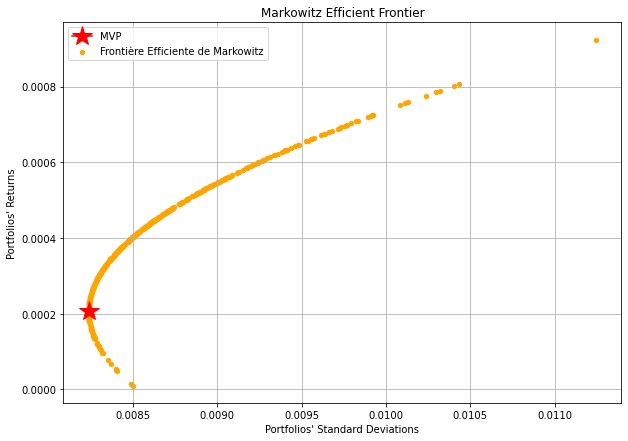

In [8]:
def weights_list(n):
    k = np.random.rand(n)
    return k / np.sum(k)

def analyse_moyenne_variance_risked_pf(returns, var_returns, nb_of_assets, number_of_simulations):
    portfolio_returns, portfolio_optimized_stds, portfolio_optimized_allocations = [], [], []
    for _ in range(number_of_simulations):
        returns_m = np.asmatrix(returns.mean())
        vars_m = np.asmatrix(var_returns)

        # Random portfolios
        w = np.asmatrix(weights_list(n))
        portfolio_return = w * returns_m.T
        portfolio_returns.append(portfolio_return)

        #Optimisation
        e = np.asmatrix(np.ones(nb_of_assets))
        inv_vars_m = np.linalg.inv(vars_m)
        A = e * inv_vars_m * returns_m.T
        B = returns_m * inv_vars_m * returns_m.T
        C = e * inv_vars_m * e.T
        d = B*C - np.power(A, 2)
        f1 = inv_vars_m * returns_m.T
        f2 = inv_vars_m * e.T

        w_optimized = (1/d) * ((C * portfolio_return - A) * f1.T + (B - A * portfolio_return) * f2.T)
        portfolio_optimized_allocations.append(w_optimized)

        portfolio_optimized_stds.append(np.sqrt(w_optimized * vars_m * w_optimized.T))

    return portfolio_returns, portfolio_optimized_stds, portfolio_optimized_allocations

# ------------------ Parameters ------------------ 
n = len(tickers)
number_of_simulations = 500

# ------------------ Portefeuille de variance minimale ------------------
portfolio_returns, portfolio_optimized_stds, portfolio_optimized_allocations = analyse_moyenne_variance_risked_pf(returns, var_returns, n, number_of_simulations)
mvp_std = np.min(portfolio_optimized_stds)
index_mvp_std = portfolio_optimized_stds.index(mvp_std)
mvp_return =  portfolio_returns[index_mvp_std]
mvp_allocation = portfolio_optimized_allocations[index_mvp_std]

print("--- MVP --- ")
print("MVP Return: ", mvp_return)
print("MVP Std: ", mvp_std)
print("MVP Allocation: ", 100*mvp_allocation)


# ------------------ Fontière efficiente ------------------
plt.figure(figsize=(10, 7))
plt.scatter(portfolio_optimized_stds, portfolio_returns, color="orange", marker="o", s=19, label="Frontière Efficiente de Markowitz")
plt.plot(mvp_std, mvp_return, label = "MVP", marker="*", color="red", markersize=20)
plt.title("Markowitz Efficient Frontier")
plt.xlabel("Portfolios' Standard Deviations")
plt.ylabel("Portfolios' Returns")
plt.grid()
plt.legend()

Nous avons trouver ci-dessus le point associé au portefeuille de variance minimale par une méthode numérique "np.min" qui utilise l'algorithme de tri 'quicksort' très efficace et d'ailleurs la plus efficace de tous les algo de tri avec une complexité $O(n*log(n))$.

Cependant nous pouvons très facilement trouver une solution fermée à ce problème, puisque ce portefeuille se situe au point où la tangente est verticale par rapport à la frontière. Ce qui revient à résoudre :

$$
\frac{\partial \sigma_p^2}{\partial \bar{r_p}} = 0
$$

$$
\begin{align*}
==> \bar{r_p} = \frac{A}{C} \\
==> \sigma_p^2 = \frac{1}{C}
\end{align*}
$$

Pour rappel les valeur de A et C ont été déterminées dans la résolution du problème d'optimisation plus haut et valent toujours respectivement:

- $
e^T \cdot {\Sigma}^{-1} \cdot \mu
$
- $
e^T \cdot {\Sigma}^{-1} \cdot e
$

### Quelques conclusions graphiques quant à l'application

L'ensemble des portefeuilles qu'il est possible de construire à partir des n actifs est contenus dans l'air contenue à l'intérieur de l'hyberbole.

Les portefeuilles dont l'esperance de rentabilité se trouve en dessous de A/C sont dominés c'est à dire qu'il existe pour chacun des portefeuilles de cette portion de la courbe un autre portefeuille dont l'espérance de rentabilité est plus élevé pour une exposition au risque équivalente. Il s'agit du point sympétriquement opposé et qui appartient à la portion de la courbe que l'on appelle frontière efficiente.

Ainsi, nous comprenons que dans le cadre de l'analyse moyenne-variance il nous faudra nous concentrer sur les portefeuilles contenue dans l'air au dessus de la droite horizontale d'équation: $\bar{r_p} = \frac{A}{C}$

Pour Markowitz (dans le cadre de son analyse moyenne-variance intégralement composé d'actifs risqué), un investisseur rationnel devra choisir le portefeuille minimisant la variance pour une espérance de rentabilité supérieur à celle du portefeuille de variance minimale.

Plus tard, il sera intéressant de déterminer quelles conditions permettent de determiner les portefeuilles efficients dont les poids sont strictement positifs, i.e. les portefeuilles qui n'ont pas recours à de la vente à découvert. Certains fonds sous la régulation UCITS n'ont pas le droit d'avoir recours à ce genre de gestion qui exposerait à un risque plus élevé les épargnants.

### Cas à n actifs risqués et un actif sans risque

Nous prendrons conventionnelement comme actif sans risque une obligation d'Etat à taux fixe moyen terme (10 ans) de très bonne notation.

Précédement, nous avons mené une analyse moyenne variance dans le cas où le marché ne comportait aucun actif sans risque ce qui ne constitue pas toujours une bonne approximation et une approche rationnelle. Cependant la conjoncture de ces 5 dernières années (entre 2015-2022) avec la baisse des taux d'intérêts (jusqu'à atteindre des niveaux négatifs) ont été une conjoncture qui pouvait justifier la rationnalité de cette approche.

Plaçons nous désormais dans un contexte de niveaux d'intérêts élevés un peu comme on est entrain de connaitre actuellement depuis un an. 

Notons $w_0$ la portion de la richesse investie dans l'actif sans risque, soit:
$$
w^T \cdot e + w_0 = 1 
$$

Ainsi, l'énoncé de notre problème d'optimisation sous contrainte a changé pour devenir:

$$
Min_w w^T \Sigma w
$$

$$ s.t. : w^T\cdot\mu + (1 -  w^T \cdot e) R_f = \bar{r_p} $$

Ainsi, via la méthode du Lagrangien nous transformons ce problème d'optiomisation sous contrainte en un problème d'optimisation libre dont la fonction objectif est: 

$$
Min_w(L(w, \lambda) = w^T \Sigma w + \lambda \cdot (w^T \cdot \mu + (1 -  w^T \cdot e) R_f))
$$

Les conditions du premier ordre nécessaires et suffisantes pour un minimum global sont:

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial w} &= 2 \Sigma w + \lambda (\mu - e R_f) = 0 \\
\frac{\partial \mathcal{L}}{\partial \lambda} &= w^T \mu + (1 - w^T e) R_f = 0 \\
\end{align*}
$$

Après résolution, on obtient comme valeur de w:

$$
w = \Sigma^{-1} (\mu - e R_f) \cdot \frac{\bar{r_p} - R_f}{(\mu - e R_f)^T \Sigma^{-1} (\mu - e R_f)}
  = \Sigma^{-1} (\mu - e R_f) \cdot \frac{\bar{r_p} - R_f}{B - 2AR_f + C R_f^2}
$$

Ainsi, la variance d'un portefeuille de la frontière efficiente s'écrit:

$$
\sigma_p^2(\bar{r_p}) = \frac{(\bar{r_p} - R_f)^2}{B - 2AR_f + C R_f^2}
$$

On a donc pour un portefeuille de la frontière efficient un écart type défini par morceaux tel que:

$$
\frac{(\bar{r_p} - R_f)}{\sqrt(B - 2AR_f + C R_f^2)}, si \bar(r_p) \geq R_f \\
\frac{- (\bar{r_p} - R_f)}{\sqrt(B - 2AR_f + C R_f^2)}, si \bar(r_p) \leq R_f 
$$

<u> Conclusion </u>

Ainsi, en présence d'un actif sans risque, la frontière efficiente est la réunion de demi-droite se rejoignant au point de coordonnés (0, Rf) (Pour rappel la frontière efficiente se trace dans le plan $(\sigma_p, \bar{r_p})$

### (Application) Cas d'un portefeuille à n actifs risqué et un actif sans risque

In [9]:
data

,AMZN,BAC-PE,KO,META,MSFT,XOM
Date,,,,,,
2022-01-03 00:00:00-05:00,170.404495,23.084217,56.725559,338.540009,330.092285,60.127102
2022-01-04 00:00:00-05:00,167.522003,22.934616,57.672581,336.529999,324.432129,62.388733
2022-01-05 00:00:00-05:00,164.356995,22.820967,58.150875,324.170013,311.977875,63.164696
2022-01-06 00:00:00-05:00,163.253998,22.839121,57.844772,332.459991,309.512665,64.650360
2022-01-07 00:00:00-05:00,162.554001,22.816517,57.710846,331.790009,309.670471,65.180283
...,...,...,...,...,...,...
2023-07-25 00:00:00-04:00,129.130005,20.527439,62.250000,294.470001,350.980011,105.680000
2023-07-26 00:00:00-04:00,128.149994,20.753448,63.049999,298.570007,337.769989,105.089996
2023-07-27 00:00:00-04:00,128.250000,20.512701,62.439999,311.709991,330.720001,105.419998


In [10]:
returns

,AMZN,BAC-PE,KO,META,MSFT,XOM
Date,,,,,,
2022-01-04 00:00:00-05:00,-0.016916,-0.006481,0.016695,-0.005937,-0.017147,0.037614
2022-01-05 00:00:00-05:00,-0.018893,-0.004955,0.008293,-0.036728,-0.038388,0.012438
2022-01-06 00:00:00-05:00,-0.006711,0.000796,-0.005264,0.025573,-0.007902,0.023520
2022-01-07 00:00:00-05:00,-0.004288,-0.000990,-0.002315,-0.002015,0.000510,0.008197
2022-01-10 00:00:00-05:00,-0.006570,0.002184,0.001657,-0.011212,0.000732,-0.005952
...,...,...,...,...,...,...
2023-07-25 00:00:00-04:00,0.002562,0.006505,-0.003362,0.009808,0.017009,0.001516
2023-07-26 00:00:00-04:00,-0.007589,0.011010,0.012851,0.013923,-0.037638,-0.005583
2023-07-27 00:00:00-04:00,0.000780,-0.011600,-0.009675,0.044010,-0.020872,0.003140


In [11]:
var_returns

,AMZN,BAC-PE,KO,META,MSFT,XOM
AMZN,0.000809,0.000091,0.000093,0.000639,0.000421,0.000098
BAC-PE,0.000091,0.000112,0.000028,0.000102,0.000070,0.000030
KO,0.000093,0.000028,0.000121,0.000065,0.000086,0.000039
META,0.000639,0.000102,0.000065,0.001384,0.000462,0.000062
MSFT,0.000421,0.000070,0.000086,0.000462,0.000435,0.000061
XOM,0.000098,0.000030,0.000039,0.000062,0.000061,0.000414


Taux sans risque équivalent:  4%
Taux sans risque équivalent:  0.04
Tickers:  ['MSFT', 'KO', 'XOM', 'AMZN', 'BAC-PE', 'META']

--- MVP --- 
MVP Return:  [[0.00015386]]
MVP Std:  4.3282340494434967e-07
MVP Allocation: 
Risked Assets: [[-0.0008104785158177772], [-0.001989595802510277], [0.00044799317899335344], [0.00040145092674568873], [0.0004438279145431398], [0.0018607068103278328]]
Unrisked Asset: [[99.9996461]]


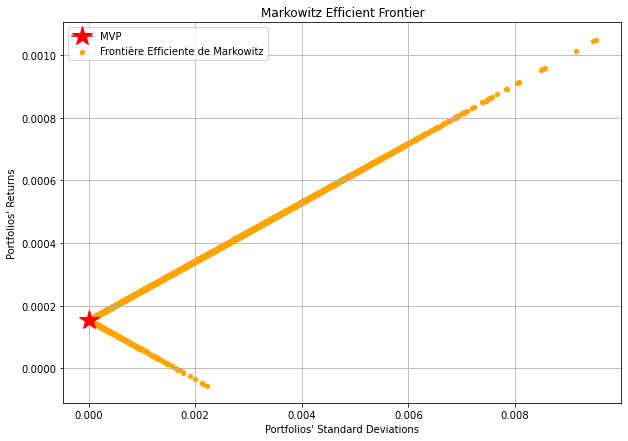

In [12]:
def analyse_moyenne_variance_less_risky_pf(returns, var_returns, r_f, nb_of_assets, number_of_simulations):
    r_f = np.power((1 + r_f), 1/255) - 1
    portfolio_returns, portfolio_optimized_stds, portfolio_optimized_allocations = [], [], []
    for _ in range(number_of_simulations):
        returns_m = np.asmatrix(returns.mean())
        vars_m = np.asmatrix(var_returns)

        # Rendements des portefeuilles
        w = np.asmatrix(weights_list(n))
        portfolio_return = w * returns_m.T
        portfolio_returns.append(portfolio_return)

        #Optimisation
        inv_vars_m = np.linalg.inv(vars_m)
        e = np.asmatrix(np.ones(nb_of_assets))
        A = e * inv_vars_m * returns_m.T
        B = returns_m * inv_vars_m * returns_m.T
        C = e * inv_vars_m * e.T

        w_optimized = inv_vars_m.T * (returns_m - e * r_f).T * (portfolio_return - r_f) / (B - 2 * A * r_f + C * r_f**2)
        portfolio_optimized_allocations.append(w_optimized)

        if portfolio_return >= r_f:
            std_optimized = (portfolio_return - r_f)/np.sqrt(B - 2 * A * r_f + C * r_f**2)
            portfolio_optimized_stds.append(std_optimized)
        else:
            std_optimized = - (portfolio_return - r_f)/np.sqrt(B - 2 * A * r_f + C * r_f**2)
            portfolio_optimized_stds.append(std_optimized)
    
    return portfolio_returns, portfolio_optimized_stds, portfolio_optimized_allocations

    # ------------------ Paramètre ------------------
number_of_simulations = 5000
r_f = 0.04
print("Taux sans risque équivalent: ", "4%")
print("Taux sans risque équivalent: ", r_f) #Journalier
print("Tickers: ", tickers)

# ------------------ Portefeuille de variance minimale ------------------
portfolio_returns, portfolio_optimized_stds, portfolio_optimized_allocations = analyse_moyenne_variance_less_risky_pf(returns, var_returns, r_f, n, number_of_simulations)
mvp_std = np.min(portfolio_optimized_stds)
index_mvp_std = portfolio_optimized_stds.index(mvp_std)
mvp_return  = portfolio_returns[index_mvp_std]
mvp_allocation = portfolio_optimized_allocations[index_mvp_std]

print("\n--- MVP --- ")
print("MVP Return: ", mvp_return)
print("MVP Std: ", mvp_std)
print("MVP Allocation: ")
print("Risked Assets:", (100*mvp_allocation).tolist())
print("Unrisked Asset:", 100*(1 - sum(mvp_allocation)))

# ------------------ Fontière efficiente ------------------
plt.figure(figsize=(10, 7))
plt.scatter(portfolio_optimized_stds, portfolio_returns, color="orange", marker="o", s=19, label="Frontière Efficiente de Markowitz")
plt.plot(mvp_std, mvp_return, label = "MVP", marker="*", color="red", markersize=20)
plt.title("Markowitz Efficient Frontier")
plt.xlabel("Portfolios' Standard Deviations")
plt.ylabel("Portfolios' Returns")
plt.grid()
plt.legend()

#### Conclusion graphique

Nous observons ci-dessus la frontière efficiente d'un portefeuille contenant 6 actifs risqués (actions) et un actif sans risque (obligation d'état américain).

A l'instar de l'analyse moyenne-variance sur un portefeuille exclusivement risqué, la repartition des portefeuilles met en évidence encore une fois qu'il existe plusieurs portefeuilles exposés à un même niveau de risque sur la base des mêmes actifs. Ainsi, nous comprendrons que la branche décroissante représente l'ensemble des portefeuilles qui maximise le risque et la branche croissante (frontière efficiente) ceux qui le minimise pour un même niveau de risque.

Le marker étoile rouge représente le portefeuille de variance minimale qui sera, dans ce cas de figure d'après étude analytique, toujours de coordonnées (0, Rf) qui représente le portefeuille où l'on alloue pratiquement l'intégralité du poids à l'actif sans risque.

### Comparaison avec le portefeuille risk only

Comparons désormais les résultats d'un tel portefeuille avec celui d'un portefeuille risqué. Dans le cadre d'un portefeuille risqué, le portefeuille de minimum variance correspond au point de coordonnées $(1/\sqrt C, A/C)$ sur le plan  (𝜎𝑝,𝑟𝑝¯)

#### Cas Rf < A/C

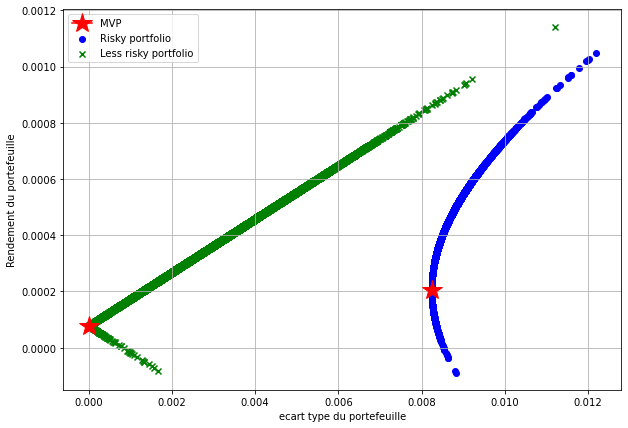

In [13]:
returns_risky_pf, stds_risky_pf, alloc_risky_pf = analyse_moyenne_variance_risked_pf(returns, var_returns, n, 5000)
returns_less_risky_pf, stds_less_risky_pf, alloc_less_risky_pf = analyse_moyenne_variance_less_risky_pf(returns, var_returns, 0.02, n, 5000)

plt.figure(figsize=(10, 7))
# MVPs
### risky
mvp_std = np.min(stds_risky_pf)
index_mvp_std = stds_risky_pf.index(mvp_std)
mvp_return  = returns_risky_pf[index_mvp_std]
plt.plot(mvp_std, mvp_return, label = "MVP", marker="*", color="red", markersize=20)

###Less risky
mvp_std = np.min(stds_less_risky_pf)
index_mvp_std = stds_less_risky_pf.index(mvp_std)
mvp_return  = returns_less_risky_pf[index_mvp_std]
plt.plot(mvp_std, mvp_return, marker="*", color="red", markersize=20)

# Courbes
plt.scatter(stds_risky_pf, returns_risky_pf, marker="o", color="blue", label="Risky portfolio")
plt.scatter( stds_less_risky_pf, returns_less_risky_pf, marker="x", color="green", label="Less risky portfolio")
plt.xlabel("ecart type du portefeuille")
plt.ylabel("Rendement du portefeuille")
plt.grid()
plt.legend()
plt.show()

Dans ce cas présent, nous avons un taux sans risque inférieur à A/C qui correspond au rendement espéré du portefeuille de variance minimale exclusivement exposé à des actifs risqués. 

Nous pouvons conjecturer graphiquement que si le taux sans risque est inférieur à A/C alors la demi-droite efficiente  de l'ensemble des portefeuille contenant un actif non risqué est tangent à la frontière efficiente du second.

<u> Démonstration </u>

Nous devons trouver le point d'intersection entre les droites efficientes (portions de courbes croissantes) de la courbe verte et de la courbe bleue.

Notons ce portefeuille $_{inter}$.
Tout d'abord notons que ce portefeuille doit vérifier $w_0 = 0$ tel que: $ e^T w = 1$

En substituant à l'équation: $ w = \Sigma^{-1} (\mu - e R_f) \cdot \frac{\bar{r_p} - R_f}{B - 2AR_f + C R_f^2}$

Nous obtenons:

$ \bar{r_p} - R_f = \frac{B - 2AR_f + C R_f^2}{A - C R_f}$

Donc, 

$$
w_{inter} = \frac{\Sigma^{-1}(\mu - e R_f)}{A - C R_f} \\
E(R_{inter}) = \frac{B - A R_f}{A - C R_f} \\
\sigma^2(R_{inter}) = \frac{B - 2AR_f + C R_f^2}{(A - C R_f)^2}
$$

Ainsi, nous avons montré dans cette partie que si $ R_f < A/C $ Alors, leur portefeuille commun se siue sur la frontière efficiente.

Notez de même que les portefeuilles efficients sur la portion de la demi-droite avant tangence correspondent aux portefeuilles où $w_0 >= 0$, au dela nous nous retrouvons avec des portefeuilles à allocation négative sur l'actif sans risque, ce qui n'est pas réaliste.

Nouvelle version du théorème de séparation à deux fonds:

Dans un marché contenant un actif sans risque, tout portefeuille peut être perçu comme une combinaison linéaire de deux portefeuille un portefeuille composé de l'actif sans risque et un portefeuille composé des actifs risqués.

Dans ce modèle, tous les investisseurs se situerait sur cette demi droite en fonction de leur richesse, de leur niveau d'aversion au risque. Un investisseur ayant moins d'aversion au risque placera un portion de richesse non nulle sur le portefeuille $w_inter$. Il pourrait meme faire jouer un effet de levier en allouant plus d 100% aux actifs risqués et en vendant à découvert l'actif sans risque.

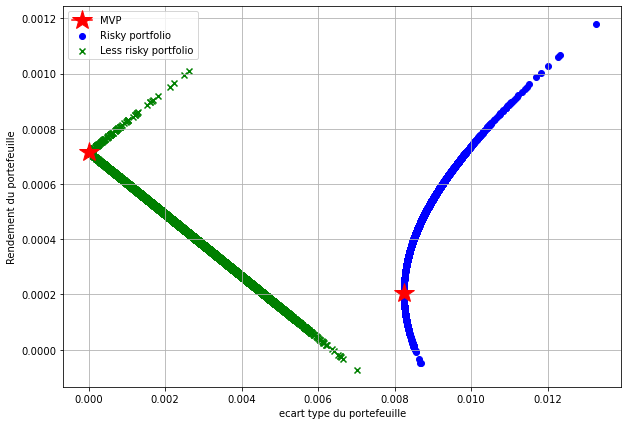

In [14]:
#### Cas Rf > A/C

returns_risky_pf, stds_risky_pf, alloc_risky_pf = analyse_moyenne_variance_risked_pf(returns, var_returns, n, 5000)
returns_less_risky_pf, stds_less_risky_pf, alloc_less_risky_pf = analyse_moyenne_variance_less_risky_pf(returns, var_returns, 0.2, n, 5000)

plt.figure(figsize=(10, 7))
# MVPs
### risky
mvp_std = np.min(stds_risky_pf)
index_mvp_std = stds_risky_pf.index(mvp_std)
mvp_return  = returns_risky_pf[index_mvp_std]
plt.plot(mvp_std, mvp_return, label = "MVP", marker="*", color="red", markersize=20)

###Less risky
mvp_std = np.min(stds_less_risky_pf)
index_mvp_std = stds_less_risky_pf.index(mvp_std)
mvp_return  = returns_less_risky_pf[index_mvp_std]
plt.plot(mvp_std, mvp_return, marker="*", color="red", markersize=20)

# Courbes
plt.scatter(stds_risky_pf, returns_risky_pf, marker="o", color="blue", label="Risky portfolio")
plt.scatter( stds_less_risky_pf, returns_less_risky_pf, marker="x", color="green", label="Less risky portfolio")
plt.xlabel("ecart type du portefeuille")
plt.ylabel("Rendement du portefeuille")
plt.grid()
plt.legend()
plt.show()

Dans ce cas de figure, le taux sans risque est supérieur au rendement du portefeuille de variance minimale 
et on peut conjecturer manière analogue à la précédente étude, que la demi-droite des portefeuilles dominés est tangente à la portion de courbe des protefeuilles risqués dominés.

Ce cas de figure permet d'avoir des portfeuilles avec un vrai placement sans risque plus optimisés qu'un portfeuille risqué sur les deux demi droites et doit décourager l'investisseur à placer dans des portefeuilles dont l'écart type est inclus dans l'intervalle $[0, 1/\sqrt C]$

### Sensibilités du portefeuille

Comme nous avons pu le voir dans les sections précédentes, l'analyse moyenne-variance repose fortement sur le calcul des vecteurs de rendements et de la matrice de variance-covariance. 
Cette approche implique quelques limites:

- la considération de ce vecteur et de cette matrice comme stationnaires, ce qui peu sur le long-moyen terme dans des marchés liquides être une approximation valable mais PAS TOUOURS.

- Les portefeuilles institutionnelles exposant l'épargne public sont soumis à des contraintes de diversification en terme de nombres d'actifs ce qui rend les calculs assez fastidieux.

- Il y a aussi les problèmes inhérent à l'inversion de la matrice de variance-covariance qui complique la résolution

Cependant, il existe des méthodes basées sur des hypothèses simplificatrices qui permettent de réduire l'impact de ces limites:

- Modèles d'indices pour modéliser les fluctuations des rendements des titres financiers
- Supposer que les corrélations des titres de même catégories restes constantes

<u> Quelques méthodes </u>


- Modèle indiciel

-- Modèle de marchés à indice unique ou multi-indice -- 

Modèle de marché à indice unique

Dans cette situation, il sera théoriquement suffisant de calculer la covariance entre le rendement du chaque titre et celui de l'indice, ce qui reduit la complexité de calcul passant d'une complexité quadratique à une complexité linéaire.

Modèle de marché multi indice

Dans cette situation, il sera théoriquement suffisant de regrouper les actifs par indice et d'appliquer la covariance indicielle juste.

-- Méthode d'Elton, Gruber et Padberg --

Cette méthode consiste à classé les actifs par ratio de Treynor, selectionné l'ensemble des titres supérieurs à un ratio seuil.

- Modèles de correction moyenne

Modèle de la moyenne générale qui présuppose que tous les titres appratiennent à la même catégorie et que leur coefficient de corrélation est égal à la moyenne des coefficients de corrélations observés entre les actifs.

Modèle de la moyenne générale par secteur qui présuppose que tous les titres appartiennent au moins à une catégorie et que leur coefficient de corrélation est constant vis à vis de cette catégorie et est égal à la moyenne des coefficients de corrélations observés dans la catégorie.

Conclusions empiriques sur les différentes approches

L'estimation directe de la matrice de variances-covariances sur des données historiques ne fournit pas une bonne prédiction des corrélations futurs. Les modèles à indices ou à moyenne permettent une meilleure précision en réduisant l'impact des fluctuation, cependant le risque d'estimation n'est qu'en partie supprimé.

Travaux et assentiment général:

Best et Grauer (1991) ont démontré empiriquement que la prise en compte d'un certain nombre de contraintes portant notamment sur les ventes à découvert permettent de réduire en partie les conséquences des erreurs d'estimation.

Frost et Savarion (1988) ont démontré empiriquement que le risque d'estimation était bien plus fort sur les rendements plutôt que sur les variances-covariances. Ils ont ainsi démontré que dans un cas de fort risque d'estimation il sera judicieux de réduire ce risque en équipondérant le portefeuille.

### Applications Analyse Moyenne-Variance avec hypothèses simplificatrices et methodes de corrections

Ainsi, mettons nous au niveau des gestionnaires institutionnelles qui doivent répondre à certaines exigences de profondeur de portefeuilles qui peuvent contenir jusqu'à plusieurs centaines de titres.

L'idée dans cette section est alors d'appliquer les méthodes de simplification et d'optimisation de calculs énoncées dans la précédente partie.

Un portefeuille aussi profond necessite une automatisation du processus de calcul et une base de donnée tickers.
Pour ce faire, j'ai trouvé sur internet un CSV assez complet mais dont la dernière mise à jour date de 2017. On aura alors potentiellenement des tickers obsolétes mais heureusement la bibliothèque yfinance gère cette exception et pourra malgré cela continuer à boucler.  

In [24]:
start = "2022-08-01"
end = "2023-08-01"
tickers_data = pd.read_excel("Ressources/tickers.xlsx", sheet_name="Stock")
tickers_data_usa = tickers_data[tickers_data["Country"] == "USA"].dropna()
tickers_data_usa

,Ticker,Name,Exchange,Category Name,Country
1,AAPL,Apple Inc.,NMS,Electronic Equipment,USA
2,BAC,Bank of America Corporation,NYQ,Money Center Banks,USA
3,AMZN,"Amazon.com, Inc.",NMS,Catalog & Mail Order Houses,USA
4,T,AT&T Inc.,NYQ,Telecom Services - Domestic,USA
5,GOOG,Alphabet Inc.,NMS,Internet Information Providers,USA
...,...,...,...,...,...
104966,INTZ,Intrusion Inc.,PNK,Security Software & Services,USA
104992,INVU,"Investview, Inc.",PNK,Business Services,USA
105102,LTM,LATAM Airlines Group S.A.,NYQ,Sporting Activities,USA
105690,PRHL,Premier Holding Corporation,PNK,Diversified Utilities,USA


#### Modèle de marché à indice unique

Appliquons ce modèle en selectionnant des big et mega caps americaines (selection aléatoire pour le moment, les critères de screening seront vu plus tard) et en utilisant tout naturellement comme indice de marché le S&P 500 (indice le plus représentatif du marché action américain).

### Contraintes supplémentaires

Pour l'instant nous n'avons résolu que des problèmes d'optimisations avec une seule contrainte, la contrainte de budget qui permet une utilisation globale de la richesse disponible: $ w^T e = 1 $

Or, il est tout à fait possible d'ajouter des contraintes supplémentaires à notre problème, tel que des coûts de transaction, des plafonds et des seuils d'allocations, ... . Formellement, il s'agit de résoudre des programmes d'optimisation du type: 

$$ 
Min_w(w^T \Sigma w) \\
w^T e = 1 \\
w € K \\
$$

Ceci fait précisément l'objet de ce que l'on appelle la programmation convexe qui consiste à maximiser ou minimiser une fonction prenant ces valeurs dans un ensemble convexe. Cette exercice peut être particulièrement difficile sauf dans le cas particulier où K est un cône.

Algorithmes de résolutions connus: Frank et Wolfe (1956) , Perold (1984), Nesterov et Nemirovski (1995)

<u> Exemple d'ensemble K et de contraintes </u> 

L'ensemble K peut correspondre à un intervalle dans lequel les poids doivent prendre leur valeur, un ensemble du type: $ A \leq w \leq B $

Les gestionnaires institutionnelles doivent necessairement utilisés ce type de contrainte pour répondre à des exigences réglementaire pour des soucis de diversification en terme de nombre d'actifs sous gestions et de poids alloués à chacun d'entre eux ce qui vise à réduire leur impact individuel.

Dans le cadre d'une stratégie du type constant mix, il peut y avoir aussi des contraintes de rebalancement en limitant la somme des achats de titres:
$$
V_0 \cdot \Sigma_i Max(w_i - w_0, 0) \leq s
$$